## Exercise 5

### General Instructions

Simulate and plot the LFPs and CSD evoked a cortical column of 400 $\mu m$ radius consisting of a L2/3, L4 and L5 excitatory population and an inhibitory PV cell population. The network is designed to have a realistic distribution of synaptic connections and neuron types, with basal and apical dendritic synapses included. We provide the built network SONATA files (network*) for a nextwork with basal and apical synapses, only basal synapses, and only apical synapses, respectively. Use `BioNet` to run the simulations of the three networks and compared the evoked LFPs and CSDs.

### 1. Generate the simulation config.json file:
- The config.json file should include the following parameters:
  - duration: 3 seconds
  - dt: 0.1 ms
  - reports: add 'ecp' recordings to the `reports` section to record the LFPs.
      - `electrode_positions`: path to the csv file containing the electrode positions. File provided in [components/electrodes](components/electrodes).
  - input: use the external input created in step 1.1.2
  - output: save the simulation results in a folder named [outputs](outputs)

`Note`: You can use `config.lfp.json` file as a template. You can modify it to suit your simulation needs.

In [1]:
import json

# Load the existing config file
with open("config.lfp.json", "r") as f:
    config = json.load(f)

# Create config for basal synapses
basal_config = config.copy()
basal_config["manifest"]["$NETWORK_DIR"] = "$BASE_DIR/network_basalsynapses"
basal_config["manifest"]["$OUTPUT_DIR"] = "$BASE_DIR/output_basalsynapses"

with open("config.lfp_basal.json", "w") as f:
    json.dump(basal_config, f, indent=2)


# Create config for apical synapses
apical_config = config.copy()
apical_config["manifest"]["$NETWORK_DIR"] = "$BASE_DIR/network_apicalsynapses"
apical_config["manifest"]["$OUTPUT_DIR"] = "$BASE_DIR/output_apicalsynapses"

with open("config.lfp_apical.json", "w") as f:
    json.dump(apical_config, f, indent=2)

print("Generated configuration files for basal and apical synapses simulations.")

Generated configuration files for basal and apical synapses simulations.


### 2. Run the simulation:
- Use `BioNet` to run the simulation with the generated config.json file. The simulation should be run for 3 seconds with a time step of 0.1 ms. The results should be saved in the outputs folder.
- Remember to compile the [./components/mechanisms](components/mechanisms) before running the simulation. You can do this by running the following command in the terminal:
```bash
! cd components/mechanisms && nrnivmodl modfiles
```

We've provided below the code for running the simulation of the network with basal and apical synapses. You can modify the code to run the other two networks (only basal synapses and only apical synapses) by changing the `config.lfp.json` file.

In [2]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json("config.lfp.json")
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2025-07-09 12:10:56,269 [INFO] Created log file
2025-07-09 12:10:56,369 [INFO] Building cells.
2025-07-09 12:11:00,560 [INFO] Building recurrent connections
2025-07-09 12:11:04,286 [INFO] Building virtual cell stimulations for virt_exc_spikes
2025-07-09 12:11:08,842 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2025-07-09 12:11:08,843 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2025-07-09 12:11:08,843 [INFO] Block save every 5000 steps
2025-07-09 12:15:02,689 [INFO]     step:5000 t_sim:500.00 ms
2025-07-09 12:18:54,579 [INFO]     step:10000 t_sim:1000.00 ms
2025-07-09 12:22:46,114 [INFO]     step:15000 t_sim:1500.00 ms
2025-07-09 12:26:36,875 [INFO]     step:20000 t_sim:2000.00 ms
2025-07-09 12:30:33,221 [INFO]     step:25000 t_sim:2500.00 ms
2025-07-09 12:33:54,315 [INFO]     step:30000 t_sim:3000.00 ms
2025-07-09 12:33:54,347 [INFO] Simulation completed in 22.0 minutes, 45.51 seconds 


### 3. Plot the results:
- Plot the raster plot of the network activity. The x-axis should represent time and the y-axis should represent the neuron index. Use different colors for different populations.
- Create a 2D plot of the LFPs recorded by the linear probe. The x-axis should represent time and the y-axis should represent the electrode number.

```python
_ = plot_raster(
    config_file="config.lfp.json",
    spikes_file="output_allsynapses/spikes.csv",
    title="Raster Plot for All Synapses",
    group_by="layer",
)

_ = plot_ecp(config_file="config.lfp_apical.json", report_name="cortical_electrode")
```


### 4. Calculate the CSD:
- Calculate the CSD from the simulated LFPs using the delta-iCSD method. You can find the implementation of the delta-iCSD method in the [icsd_scripts](icsd_scripts) folder.

In [1]:
import sys
import quantities as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("icsd_scripts/")

import icsd

from get_csd_input_dict import get_csd_input_dict

delta_icsd_allsynapses = get_csd_input_dict(
    "output_allsynapses/cortical_electrode.h5",
)
delta_icsd_basal = get_csd_input_dict(
    "output_basalsynapses/cortical_electrode.h5",
)
delta_icsd_apical = get_csd_input_dict(
    "output_apicalsynapses/cortical_electrode.h5",
)

In [13]:
csd_dict = dict(
    delta_icsd=icsd.DeltaiCSD(**delta_icsd_allsynapses),
    delta_icsd_basal=icsd.DeltaiCSD(**delta_icsd_basal),
    delta_icsd_apical=icsd.DeltaiCSD(**delta_icsd_apical),
)

for method, csd_obj in list(csd_dict.items()):
    csd_raw = csd_obj.get_csd()  # num_channels x trial_duration
    csd_smooth = csd_obj.filter_csd(csd_raw)  # num_channels x trial_duration

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


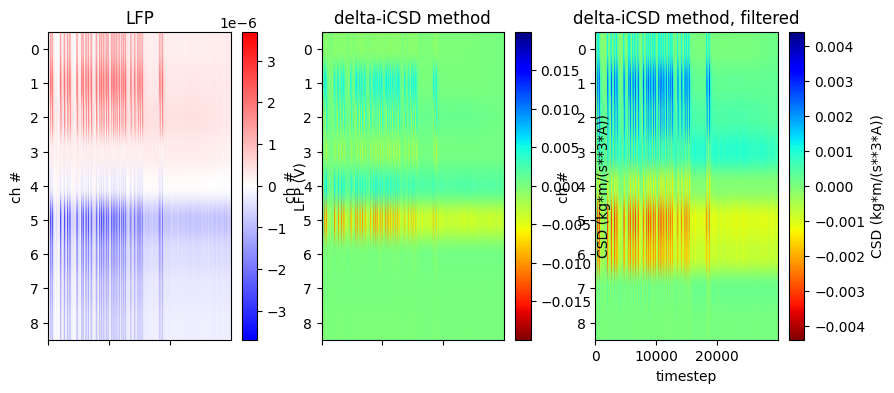

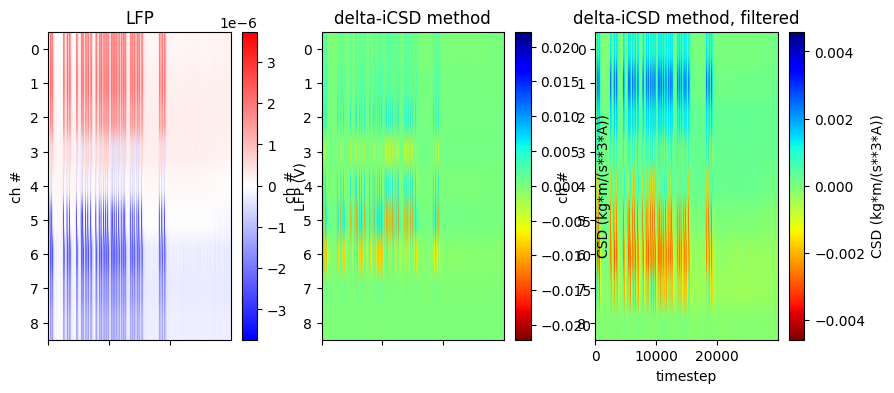

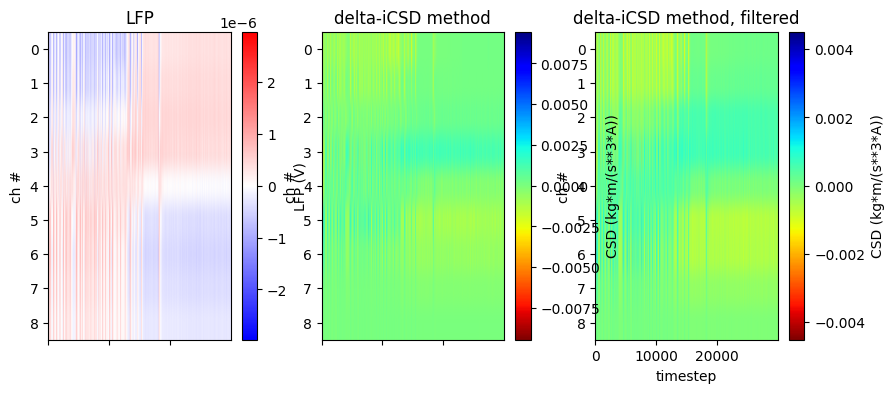

In [40]:
import matplotlib.pyplot as plt

delta_icsd_dict = dict(
    delta_icsd=delta_icsd_allsynapses,
    delta_icsd_basal=delta_icsd_basal,
    delta_icsd_apical=delta_icsd_apical,
)

# for method, csd_smooth in list(csd_smooth.items()):
for method, csd_obj in list(csd_dict.items()):
    csd_raw = csd_obj.get_csd()  # num_channels x trial_duration
    csd_smooth = csd_obj.filter_csd(csd_raw)  # num_channels x trial_duration
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    lfp_data = delta_icsd_dict[method]["lfp"]

    # plot LFP signal
    ax = axes[0]
    im = ax.imshow(
        np.array(lfp_data),
        origin="upper",
        vmin=-abs(lfp_data).max(),
        vmax=abs(lfp_data).max(),
        cmap="bwr",
    )
    ax.axis(ax.axis("tight"))
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("LFP (%s)" % lfp_data.dimensionality.string)
    ax.set_xticklabels([])
    ax.set_title("LFP")
    ax.set_ylabel("ch #")

    # plot raw csd estimate
    ax = axes[1]
    im = ax.imshow(
        np.array(csd_raw),
        # np.array(csd_raw[method]),
        origin="upper",
        vmin=-abs(csd_raw).max(),
        vmax=abs(csd_raw).max(),
        # vmin=-abs(csd_raw[method]).max(),
        # vmax=abs(csd_raw[method]).max(),
        cmap="jet_r",
    )
    ax.axis(ax.axis("tight"))
    ax.set_title(csd_obj.name)
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("CSD (%s)" % csd_raw.dimensionality.string)
    # cb.set_label("CSD (%s)" % csd_raw[method].dimensionality.string)
    ax.set_xticklabels([])
    ax.set_ylabel("ch #")

    # plot spatially filtered csd estimate
    ax = axes[2]
    im = ax.imshow(
        np.array(csd_smooth),
        origin="upper",
        vmin=-abs(csd_smooth).max(),
        vmax=abs(csd_smooth).max(),
        cmap="jet_r",
    )
    ax.axis(ax.axis("tight"))
    ax.set_title(csd_obj.name + ", filtered")
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("CSD (%s)" % csd_smooth.dimensionality.string)
    ax.set_ylabel("ch #")
    ax.set_xlabel("timestep")